In [1]:
import collections
import networkx as nx
import numpy as np
import os
import random
from sklearn import linear_model

In [49]:
# plot settings
import matplotlib.pyplot as plt

FIGSIZE_TWOCOL = (10,5)
FIGSIZE_ONECOL = (5,5)

SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Statistiche generali

In [3]:
g = nx.read_edgelist('../network/networks/edge_list.txt',
                     create_using=nx.DiGraph(), nodetype=int, data=False)

In [4]:
# Erdos-Renyi random network
er_g = nx.read_edgelist('../network/networks/er_edge_list.txt',
                                create_using=nx.DiGraph(), nodetype=int,
                                data=False)

In [5]:
# Barabasi-Albert network
ba_g = nx.read_edgelist('../network/networks/ba_edge_list.txt',
                        create_using=nx.Graph(), nodetype=int,
                        data=False)


In [6]:
def network_summary(g, undirected=True):
    """ returns dictionary with the network informations"""

    in_degrees = [d for id, d in g.in_degree()]
    out_degrees = [d for id, d in g.out_degree()]
    degrees = [d for id,d in g.degree()]
    
    g_info= {}
    g_info['N'] = nx.number_of_nodes(g)
    g_info['L'] = nx.number_of_edges(g)
    g_info['d_avg'] = int(np.mean(in_degrees))
    g_info['d_in_max'] = np.max(in_degrees)
    g_info['d_in_min'] = np.min(in_degrees)
    g_info['d_out_max'] = np.max(out_degrees)
    g_info['d_out_min'] = np.min(out_degrees)
    g_info['d_max'] = np.max(degrees)
    g_info['d_min'] = np.min(degrees)

    if(undirected):
        """undirected graph statistics, NOTE: reciprocal links are lost"""
        g_und = g.to_undirected()
        degrees_und = [d for id,d in g_und.degree()]
        g_info['d_avg_und'] = int(np.mean(degrees_und))
        g_info['d_max_und'] = np.max(degrees_und)
        g_info['d_min_und'] = np.min(degrees_und)

    return g_info

In [7]:
g_info = network_summary(g)

In [131]:
#g_info

In [77]:
er_g_info = network_summary(er_g)

In [132]:
#er_g_info

In [133]:
ba_g_info = network_summary(ba_g)

AttributeError: 'Graph' object has no attribute 'in_degree'

In [10]:
## choosing erdos-renyi probability
probER=float(g_info['d_avg_und'])/(g_info['N'])
probER

0.0008671971275996896

# Degree distribution

Questions:
- chi sono gli users che hanno il valore massimo di degree entrante/uscente?
- che caratteristiche in comune hanno?


In [11]:
in_degrees = [d for id, d in g.in_degree()]
out_degrees = [d for id, d in g.out_degree()]
degrees =[d for id,d in g.degree()]

# ordinamento
in_degrees.sort(reverse=True)
out_degrees.sort(reverse=True)
degrees.sort(reverse=True)

In [12]:
# in degree
in_degree_counts = collections.Counter(d for n, d in g.in_degree())
in_degree_counts = [in_degree_counts.get(i, 0) for i in range(max(in_degree_counts) + 1) ]
degree_in= np.arange(len(in_degree_counts))
in_degree_probs = np.array(in_degree_counts).astype(float)/g_info['N']

In [13]:
# out degree
out_degree_counts = collections.Counter(d for n, d in g.out_degree())
out_degree_counts = [out_degree_counts.get(i, 0) for i in range(max(out_degree_counts) + 1)]
degree_out= np.arange(len(out_degree_counts))
out_degree_probs = np.array(out_degree_counts).astype(float)/g_info['N']

In [14]:
# total degree
degree_counts = collections.Counter(d for n, d in g.degree())
degree_counts = [degree_counts.get(i, 0) for i in range(max(degree_counts) + 1) ] #if degree_counts.get(i,0)>0]
degree= np.arange(len(degree_counts))
degree_probs = np.array(degree_counts).astype(float)/g_info['N']

In [15]:
# Erdos-Renyi degree
er_degree_counts = collections.Counter(d for n, d in er_g.degree())
er_degree_counts = [er_degree_counts.get(i, 0) for i in range(max(er_degree_counts) + 1)]
er_degree= np.arange(len(er_degree_counts))
er_degree_probs = np.array(er_degree_counts).astype(float)/g_info['N']

In [16]:
# Barabasi-Albert degree
ba_degree_counts = collections.Counter(d for n, d in ba_g.degree())
ba_degree_counts = [ba_degree_counts.get(i, 0) for i in range(max(ba_degree_counts) + 1) ]
ba_degree= np.arange(len(ba_degree_counts))
ba_degree_probs = np.array(ba_degree_counts).astype(float)/ba_g.number_of_nodes()

m = random.randint(1, g.number_of_nodes() - 1)
##ba_g_now = nx.barabasi_albert_graph(g.number_of_nodes(), g_info['d_avg']*2)
ba_g_now = nx.barabasi_albert_graph(g.number_of_nodes(), 76)


nx.write_edgelist(ba_g_now, '../network/networks/ba_edge_list_now.txt')

# Barabasi-Albert network
ba_g = nx.read_edgelist('../network/networks/ba_edge_list_now.txt',
                        create_using=nx.Graph(), nodetype=int,
                        data=False)

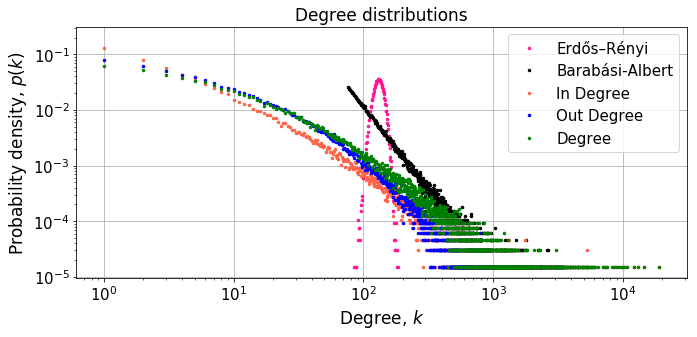

In [50]:
fig, ax = plt.subplots(figsize=FIGSIZE_TWOCOL)
MARKERSIZE=5

# random networks
plt.plot(er_degree, er_degree_probs, '.', color='deeppink',   label=u'Erdős–Rényi', markersize = MARKERSIZE)
plt.plot(ba_degree, ba_degree_probs, '.', color='black',   label=u'Barabási-Albert', markersize = MARKERSIZE)

# real network
plt.plot(degree_in, in_degree_probs, '.', color='tomato',   label='In Degree', markersize = MARKERSIZE)
plt.plot(degree_out, out_degree_probs, '.', color='blue',   label='Out Degree', markersize = MARKERSIZE)
plt.plot(degree, degree_probs, '.', color='green',   label='Degree', markersize = MARKERSIZE)


##plt.plot(range(0, len(hist)), hist, ".", color='deeppink',
##         label=u'Barabási–Albert')

plt.grid()
plt.legend()
plt.title("Degree distributions")
plt.xlabel("Degree, $k$")
plt.ylabel("Probability density, $p(k)$")                                     
plt.loglog()
plt.tight_layout()
plt.savefig("imgs/degree_distributions.pdf")                                     

In [20]:
# regression testing
begin = 30
end = 200
counts_Y = np.log(in_degree_probs[begin:end])
degree_X = np.log(degree_in[begin:end]).astype(float)
degree_X=degree_X.reshape(end-begin,1)
regr = linear_model.LinearRegression()
regr.fit(degree_X, counts_Y)
count_pred = regr.predict(degree_X)+0.5

In [21]:
print regr.coef_[0]
print regr.intercept_
print regr.score(degree_X, counts_Y)

-1.64533850716
0.285776511621
0.95378108165


In [22]:
def regression(degree, degree_probs, begin, end, h_adjust=-0, color= "black"):
    """regression analysis between begin and end, 
    plotting of the line and returns the slope"""
    counts_Y = np.log(degree_probs[begin:end])
    degree_X = np.log(degree[begin:end]).astype(float)
    degree_X=degree_X.reshape(end-begin,1)
    regr = linear_model.LinearRegression()
    regr.fit(degree_X, counts_Y)
    count_pred = regr.predict(degree_X)+h_adjust
    plt.plot( np.exp(degree_X), np.exp(count_pred), color="black")
    return -regr.coef_[0]

## In-degree distribution

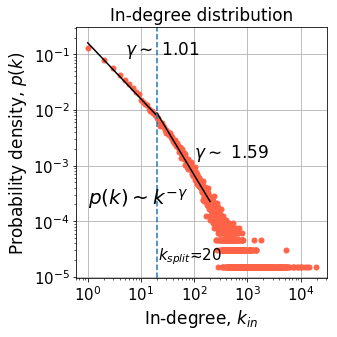

In [63]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(degree_in, in_degree_probs, '.', color='tomato',   label='In-degree', markersize = 10)
##plt.plot(degree_out, out_degree_probs, '.', color='green',   label='Original')

split =20
gamma_in_1 = regression(degree_in, in_degree_probs, 1,split).round(2)
gamma_in_2 = regression(degree_in, in_degree_probs, split,200).round(2)

plt.text(5, (float(1)/10), "$\gamma \sim $ {}".format(gamma_in_1))
plt.text(100,float(1)/700, "$\gamma \sim $ {}".format(gamma_in_2))
plt.text(1,float(1)/5000, "$p(k) \sim k^{-\gamma}  $ ",fontsize =20)
# info on the splitting
plt.axvline(split, 0,1000, linestyle='--')
plt.text(split+1, float(1)/50000, "$k_{split} \eqsim$"+"{}".format(20), fontsize=SMALL_SIZE)

plt.title("In-degree distribution")
plt.xlabel("In-degree, $k_{in}$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.tight_layout()
plt.savefig("imgs/in_degree_distribution.pdf")                                     

## Out-degree distribution

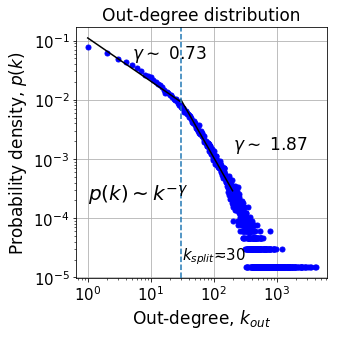

In [64]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
#fig, ax = plt.subplots(figsize = (20,10))
plt.plot(degree_out, out_degree_probs, '.', color='blue',   label='Out-degree', markersize = 10)
##plt.plot(degree_out, out_degree_probs, '.', color='green',   label='Original')

split =30
gamma_out_1 = regression(degree_out, out_degree_probs, 1,split).round(2)
gamma_out_2 = regression(degree_out, out_degree_probs, split, 200).round(2)

plt.text(5, (float(1)/20), "$\gamma \sim $ {}".format(gamma_out_1))
plt.text(200,float(1)/700, "$\gamma \sim $ {}".format(gamma_out_2))
plt.text(1,float(1)/5000, "$p(k) \sim k^{-\gamma}  $ ",fontsize =20)
# info on the splitting
plt.axvline(split, 0,1000, linestyle='--')
plt.text(split+1, float(1)/50000, "$k_{split} \eqsim$"+"{}".format(split), fontsize=SMALL_SIZE)

plt.title("Out-degree distribution")
plt.xlabel("Out-degree, $k_{out}$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.tight_layout()
plt.savefig("imgs/out_degree_distribution.pdf")                                     